# DNN and RF in TopFC analysis
Author: Meisam Ghasemi Bostanabad

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VV signal and one corresponding to the background.

In [43]:
import uproot
import numpy as np
import pandas as pd
import h5py
import awkward as ak

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

filename = {'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar.root',
 'ttbarW':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbarW.root',
 'ttbarZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbarZ.root', 
 'tttt':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/tttt.root',
 'tZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/tZ.root',
 'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/WZ.root',
 'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ZZ.root',
 'signal_up':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/signal_up.root',
 'signal_charm':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/signal_charm.root'}
upfile = {}
params = {}
df = {}

#VARS = ['f_mass4l','f_massjj'] # choose which vars to use (2d)
VARS = ['jetNo','jetPTLeading','bjetPT','elecPTLeading','met','testnonTopMass'] # choose which vars to use (2d)

for treename in filename.keys():
    upfile[treename] = uproot.open(filename[treename])
    params[treename] = upfile[treename][treename].arrays(VARS)
    df[treename] = ak.to_dataframe(params[treename])
    # add isSignal variable
    if treename.startswith("signal"): 
        df[treename]['isSignal'] = np.ones(len(df[treename])) 
    else:
        df[treename]['isSignal'] = np.zeros(len(df[treename])) 


In [44]:
df['ttbar'].head()
df['signal_up'].head()
for treename in filename.keys():
    print(treename, ":", df[treename].shape)


ttbar : (34, 7)
ttbarW : (73010, 7)
ttbarZ : (99839, 7)
tttt : (22176, 7)
tZ : (135104, 7)
WZ : (936, 7)
ZZ : (76, 7)
signal_up : (40424, 7)
signal_charm : (38502, 7)


## Define the model
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The weights are initialized using a small Gaussian random number. 
We will switch between linear and tanh activation functions for the hidden layer.
The output layer contains a single neuron in order to make predictions. 
It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [45]:
# baseline keras model
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils

NDIM = len(VARS)
inputs = Input(shape=(NDIM,), name = 'input') 
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(inputs)

# create the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6)]               0         
_________________________________________________________________
output (Dense)               (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 
We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset).
We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best `val_loss`.

In [46]:
df_all = pd.concat([df[treename] for treename in filename.keys()])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('TopFC_dense_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

## Run training 
Here, we run the training.

In [47]:
# Train classifier
history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=1000, 
                    batch_size=1024, 
                    verbose=1, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_split=0.25)

Epoch 1/1000
241/241 [==============================] - 1s 2ms/step - loss: 0.6727 - accuracy: 0.5801 - val_loss: 0.6166 - val_accuracy: 0.7348
Epoch 2/1000
241/241 [==============================] - 0s 1ms/step - loss: 0.6037 - accuracy: 0.7641 - val_loss: 0.5682 - val_accuracy: 0.8048
Epoch 3/1000
241/241 [==============================] - 0s 1ms/step - loss: 0.5601 - accuracy: 0.8050 - val_loss: 0.5341 - val_accuracy: 0.8075
Epoch 4/1000
241/241 [==============================] - 0s 1ms/step - loss: 0.5284 - accuracy: 0.8077 - val_loss: 0.5102 - val_accuracy: 0.8075
Epoch 5/1000
241/241 [==============================] - 0s 2ms/step - loss: 0.5077 - accuracy: 0.8062 - val_loss: 0.4938 - val_accuracy: 0.8075
Epoch 6/1000
241/241 [==============================] - 0s 1ms/step - loss: 0.4926 - accuracy: 0.8063 - val_loss: 0.4828 - val_accuracy: 0.8075
Epoch 7/1000
241/241 [==============================] - 0s 1ms/step - loss: 0.4828 - accuracy: 0.8068 - val_loss: 0.4756 - val_accuracy:

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

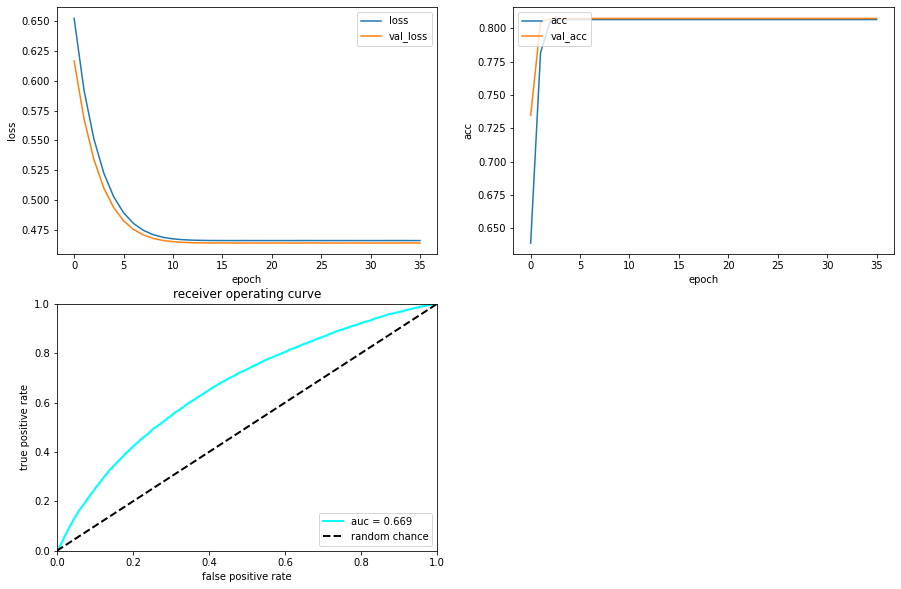

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['accuracy'], label='acc')
ax.plot(history.history['val_accuracy'], label='val_acc')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot ROC
Y_predict = model.predict(X_test)
Y_predict_train = model.predict(X_train_val)
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve')
ax.legend(loc="lower right")
plt.show()

In [49]:
Y_pred = model.predict(X)
Y_pred = Y_pred.reshape(Y_pred.shape[0])

print(accuracy_score(Y_test.round(), Y_predict.round()))
print(accuracy_score(Y_train_val.round(), Y_predict_train.round()))
print(classification_report(Y.round(), Y_pred.round(), target_names=['background', 'signal']))

df_all['dense'] = model.predict(X) # add prediction to array
#print (df_all.iloc[:5])

0.8100852220772728
0.8069099000243843


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

  background       0.81      1.00      0.89    331175
      signal       0.00      0.00      0.00     78926

    accuracy                           0.81    410101
   macro avg       0.40      0.50      0.45    410101
weighted avg       0.65      0.81      0.72    410101



# Random Forest

In [50]:
# 8. Random Forest classifier for prediction and evaluate the model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# the parameters for initializing are called hyperprameters
RF_clf = RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=30, random_state=420) # initialise your random forest classifier
RF_clf.fit(X_train_val, Y_train_val) # fit to the training data
y_pred_RF = RF_clf.predict(X_test) # make predictions on the test data

# for my own curiosity
y_pred_RF_train = RF_clf.predict(X_train_val)
#Y_pred = RF_clf.predict(X)

# See how well the classifier does, Acc = correct data / tot data
# The accuracy score is defined as the ratio of correctly identified data points to all data points.
print(accuracy_score(Y_test, y_pred_RF))
print(accuracy_score(Y_train_val, y_pred_RF_train))

print(classification_report(Y_test.round(), y_pred_RF.round(), target_names=['background', 'signal']))

0.8101096060764926
0.8070074372104364
              precision    recall  f1-score   support

  background       0.81      1.00      0.90     66444
      signal       0.60      0.00      0.00     15577

    accuracy                           0.81     82021
   macro avg       0.71      0.50      0.45     82021
weighted avg       0.77      0.81      0.73     82021



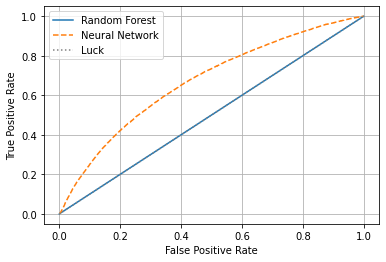

In [51]:
# Plot ROC for both DNN and RF
fpr_nn, tpr_nn, thresholds_nn = roc_curve(Y_test, Y_predict)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_pred_RF)
#roc_auc = auc(fpr, tpr)
#ax = plt.subplot(2, 2, 3)
plt.plot(fpr_rf, tpr_rf, label='Random Forest') # plot random forest ROC
plt.plot(fpr_nn, tpr_nn, linestyle='dashed', label='Neural Network') # plot neural network ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend
#plt.show()

# Plot NN output vs input variables
Here, we will plot the NN output and devision boundary as a function of the input variables.

**Question 1:** How can we fill the correct numpy arrays for plotting?

In [7]:
# Hint: We want to make a three 2D numpy arrays: 
# x values at each (x, y) grid point
# y values at each (x, y) grid point
# z values (model prediction) at each (x, y) grid point

myXI, myYI = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
# print shape
print(myXI.shape)

for i in range(0, len(myXI)):
    for j in range(0, len(myYI)):
        myXI[i,j] # x value of xi, yj point
        myYI[i,j] # y value of xi, yj point
        #myZI[i,j] = ??? # change this

myZI = model.predict(np.c_[myXI.ravel(), myYI.ravel()])
myZI = myZI.reshape(myXI.shape)

(200, 200)


**Question 2:** The code below shows how to plot the NN output. How can we plot the NN decision boundary?

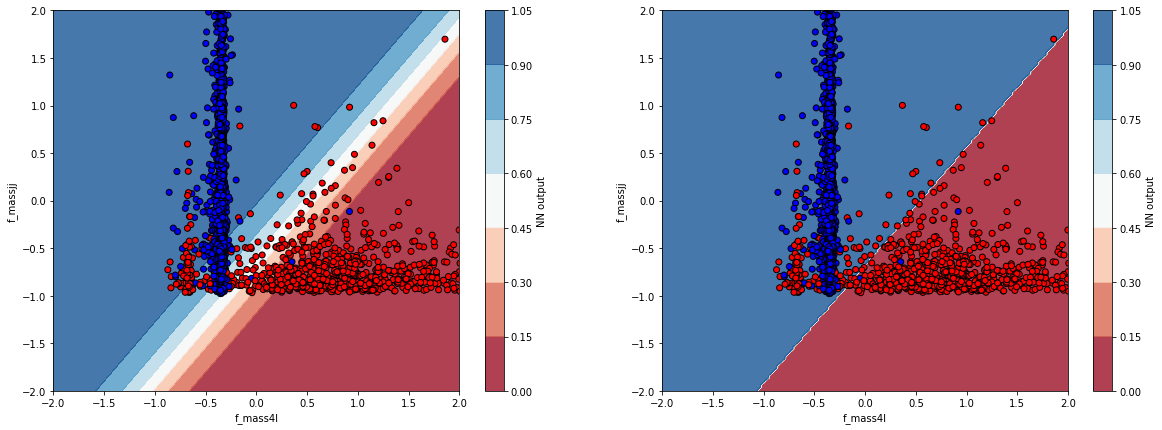

In [8]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,7))

# plot contour map of NN output
# overlaid with test data points
ax = plt.subplot(1, 2, 1)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cont_plot = ax.contourf(myXI, myYI, myZI, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

# plot decision boundary
# overlaid with test data points
ax = plt.subplot(1, 2, 2)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cont_plot = ax.contourf(myXI, myYI, myZI>0.5, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

**Question 3:** What happens if you increase/decrease the number of hidden layers?

**Question 4:** What happens if you increase/decrease the number of nodes per hidden layer?

**Question 5:** What happens if you add/remove dropout?

**Question 6:** What happens if you add/remove early stopping?

## Add prediction to `ROOT` trees
Here we'll add the precition we've computed to `ROOT` trees.

In [9]:
from root_numpy import root2array, array2root


def get_features_from_file(filename='', treename='', branches=[]):
    t = root2array(filename, treename=treename, branches=branches) # structured numpy array 
    #print t.shape 
    t = t.view(np.float32).reshape(t.shape + (-1,)) # normal numpy array (trick from https://stackoverflow.com/questions/5957380/convert-structured-array-to-regular-numpy-array)
    #print t.shape
    return t

def write_prediction_to_file(features, model, filename='',treename='',branch=''):
    y_predict_all = model.predict(features) # normal numpy array
    #print y_predict_all.shape
    y_predict_all = np.array(y_predict_all, dtype=[(branch, np.float32)]) # structured numpy array
    #print y_predict_all.shape
    array2root(y_predict_all, filename, treename=treename, mode='recreate')
    
X_all = get_features_from_file('data/ntuple_4mu_VV.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

X_all = scaler.transform(X_all)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_VV_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')

X_all = get_features_from_file('data/ntuple_4mu_bkg.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

X_all = scaler.transform(X_all)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_bkg_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')

Welcome to JupyROOT 6.14/04
